In [3]:
import geopandas as gpd
import fiona
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox
import pandas as pd
import contextily as ctx

ox.settings.use_cache = True
ox.settings.log_console = False
ox.settings.timeout = 180

# === Parametri ===
PARAMS = {
    "center_latlon": (41.940583, 12.418912),  # Santa Maria della Pietà
    "dist_m": 5000,                           # raggio in metri
    "crs_metric": "EPSG:32633",               # UTM 33N
    "use_basemap": True,                      # usa basemap CartoDB se contextily disponibile
}

path_gdb = "/home/opc/CLC2018_IT.gdb/CLC2018_IT.gdb"

# Mostriamo i layer contenuti nel geodatabase
print("📚 Layer disponibili:")
layers = fiona.listlayers(path_gdb)
print(layers)


📚 Layer disponibili:
['CLC12_IT', 'CLC18_IT', 'CHA18_IT']


In [4]:
gdf = gpd.read_file("/home/opc/CLC2018_IT.gdb/CLC2018_IT.gdb", layer="CLC18_IT")
print(gdf.shape)
print(gdf.crs)
print(gdf.head())


(115782, 7)
EPSG:32632
   Shape_Length    Shape_Area    ID CODE_18     Area_Ha Remark  \
0   7714.624097  1.369207e+06  IT_1     111  136.920735   None   
1   3034.090575  3.566751e+05  IT_2     111   35.667510   None   
2   3038.123691  4.281445e+05  IT_3     111   42.814449   None   
3   4718.345385  5.815012e+05  IT_4     111   58.150121   None   
4   4389.084380  9.243629e+05  IT_5     111   92.436291   None   

                                            geometry  
0  MULTIPOLYGON (((827133.375 3935376.25, 827238....  
1  MULTIPOLYGON (((849078.188 3975021.25, 849189....  
2  MULTIPOLYGON (((1048555.786 4076865.387, 10485...  
3  MULTIPOLYGON (((762900.438 4080883.5, 763006.7...  
4  MULTIPOLYGON (((1022712.562 4081271.25, 102276...  


In [5]:
# === 2️⃣ Crea punto di riferimento (Santa Maria della Pietà) ===
center_latlon = PARAMS["center_latlon"]
point = gpd.GeoDataFrame(
    {"name": ["Santa Maria della Pietà"]},
    geometry=[Point(center_latlon[1], center_latlon[0])],
    crs="EPSG:4326"
)

# === 3️⃣ Proietta in CRS metrico (UTM 33N per Roma) ===
crs_metric = PARAMS["crs_metric"]
point_utm = point.to_crs(crs_metric)
gdf_utm = gdf.to_crs(crs_metric)

# === 4️⃣ Crea buffer di 5 km ===
buffer = point_utm.buffer(PARAMS["dist_m"])
buffer_gdf = gpd.GeoDataFrame(geometry=buffer, crs=crs_metric)

# === 5️⃣ Ritaglia il Corine sul buffer ===
gdf_clip = gpd.overlay(gdf_utm, buffer_gdf, how="intersection")
print(f"✅ Poligoni ritagliati: {gdf_clip.shape[0]}")


✅ Poligoni ritagliati: 50


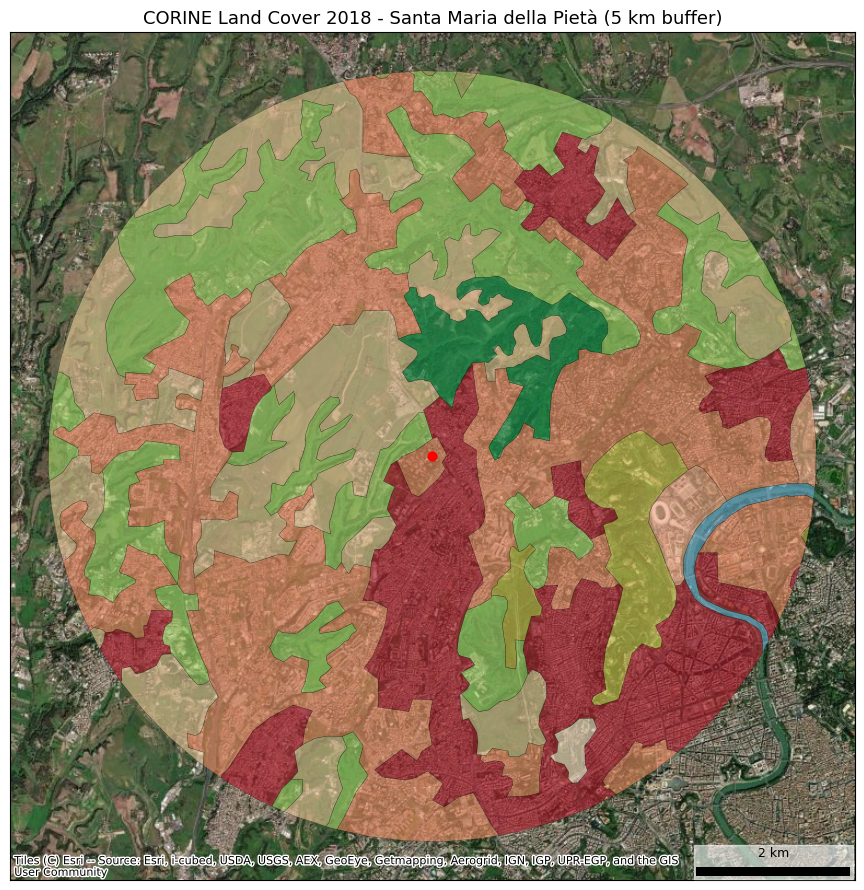

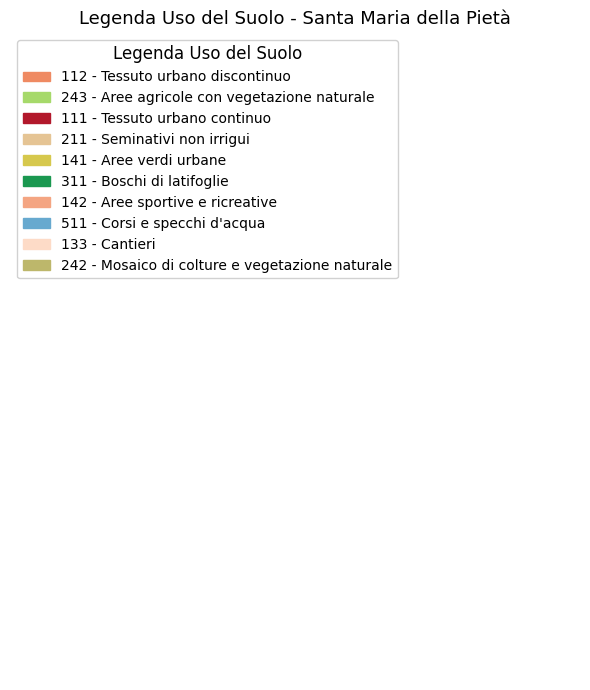

In [6]:
# ==============================================
# 1️⃣ Palette CORINE coerente
# ==============================================
import matplotlib.colors as mcolors

corine_palette = {
    '111': "#b2182b",  # urbano continuo
    '112': "#ef8a62",  # urbano discontinuo
    '133': "#fddbc7",  # cantieri
    '141': "#d6c84d",  # verde urbano
    '142': "#f4a582",  # aree sportive
    '211': "#e5c494",  # seminativi non irrigui
    '242': "#bdb76b",  # mosaico colture
    '243': "#a6d96a",  # agricole con vegetazione
    '311': "#1a9850",  # boschi di latifoglie
    '511': "#67a9cf",  # acqua
}

# ==============================================
# 2️⃣ Calcolo frequenze d’uso del suolo
# ==============================================
import pandas as pd

corine_labels_it = {
    '111': "Tessuto urbano continuo",
    '112': "Tessuto urbano discontinuo",
    '133': "Cantieri",
    '141': "Aree verdi urbane",
    '142': "Aree sportive e ricreative",
    '211': "Seminativi non irrigui",
    '242': "Mosaico di colture e vegetazione naturale",
    '243': "Aree agricole con vegetazione naturale",
    '311': "Boschi di latifoglie",
    '511': "Corsi e specchi d'acqua",
}

# Assicurati di lavorare in CRS metrico
gdf_clip = gdf_clip.to_crs(epsg=3857)
gdf_clip["area_m2"] = gdf_clip.geometry.area

# Frequenze e percentuali
df_freq = (
    gdf_clip.groupby("CODE_18")["area_m2"]
    .sum()
    .reset_index()
    .sort_values(by="area_m2", ascending=False)
)
df_freq["perc"] = 100 * df_freq["area_m2"] / df_freq["area_m2"].sum()
df_freq["descrizione"] = df_freq["CODE_18"].map(corine_labels_it)
df_freq["color"] = df_freq["CODE_18"].map(corine_palette)

# ==============================================
# 3️⃣ Mappa principale con colori CORINE coerenti
# ==============================================
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
import math

# Conversione CRS
gdf_web = gdf_clip.to_crs(epsg=3857)
point_web = point_utm.to_crs(epsg=3857)

# Correzione per la scala metrica reale (latitudine di Roma)
lat0 = point_utm.to_crs(epsg=4326).geometry.y.iloc[0]
dx_correction = math.cos(math.radians(lat0))

fig, ax = plt.subplots(figsize=(9, 9))

# --- Plot CORINE con colori personalizzati ---
gdf_web["color"] = gdf_web["CODE_18"].map(corine_palette)
gdf_web.plot(ax=ax, color=gdf_web["color"], alpha=0.6, edgecolor="k", linewidth=0.2)

# --- Punto centrale ---
point_web.plot(ax=ax, color="red", markersize=40, zorder=3)

# --- Basemap ---
ctx.add_basemap(ax, crs=gdf_web.crs, source=ctx.providers.Esri.WorldImagery)

# --- Barra di scala bianca ---
scalebar = ScaleBar(
    dx=dx_correction,
    units="m",
    dimension="si-length",
    location="lower right",
    scale_loc="top",
    box_alpha=0.6,
    box_color=(1, 1, 1, 0.5),
    color="black",
    length_fraction=0.25,
    font_properties={'size': 9},
)
ax.add_artist(scalebar)

# --- Layout pulito ---
ax.set_title("CORINE Land Cover 2018 - Santa Maria della Pietà (5 km buffer)", fontsize=13)
ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

# ==============================================
# 4️⃣ Legenda coerente e separata
# ==============================================
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(6, 7))

# Categorie effettivamente presenti nel buffer
handles = [
    mpatches.Patch(color=row["color"], label=f"{row['CODE_18']} - {row['descrizione']}")
    for _, row in df_freq.iterrows()
]

ax.legend(
    handles=handles,
    title="Legenda Uso del Suolo",
    loc="upper left",
    fontsize=10,
    title_fontsize=12,
    frameon=True,
    framealpha=0.9
)
ax.set_title("Legenda Uso del Suolo - Santa Maria della Pietà", fontsize=13)
ax.axis("off")
plt.tight_layout()
plt.show()


⬇️ Scaricamento delle aree verdi da OSM...
✅ Totale elementi scaricati: 8430
✅ Poligoni di verde utili: 2458


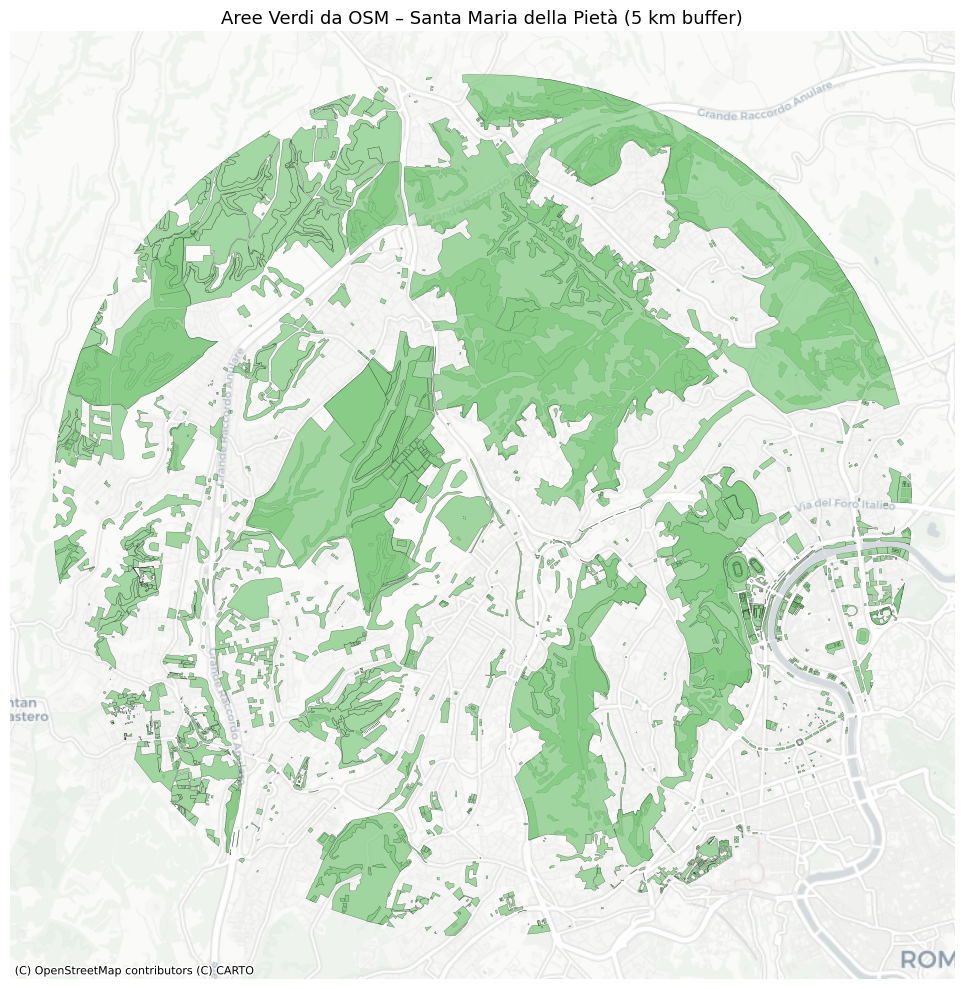

In [8]:
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point

# === PARAMETRI ===
PARAMS = {
    "center_latlon": (41.940583, 12.418912),  # Santa Maria della Pietà
    "dist_m": 5000,                           # raggio in metri
    "crs_metric": "EPSG:32633",               # UTM 33N (Roma)
}

# === 1️⃣ Costruisci AOI (buffer di 5 km) ===
lat, lon = PARAMS["center_latlon"]
gdf_pt = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326)
aoi_m = gdf_pt.to_crs(PARAMS["crs_metric"]).buffer(PARAMS["dist_m"])
aoi = aoi_m.to_crs(4326).iloc[0]  # poligono in WGS84 per query OSM
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi], crs=4326)

# === 2️⃣ TAG VERDI ESTESI (senza classificazione) ===
tags_verde = {
    "leisure": [
        "park", "garden", "recreation_ground", "nature_reserve",
        "golf_course", "dog_park", "playground", "pitch", "sports_centre",
        "stadium", "common"
    ],
    "landuse": [
        "farmland", "farmyard", "meadow", "grass", "pasture",
        "orchard", "vineyard", "plant_nursery",
        "forest", "greenfield", "recreation_ground",
        "cemetery", "village_green", "allotments",
        "flowerbed", "greenhouse_horticulture"
    ],
    "natural": [
        "wood", "scrub", "grassland", "heath", "wetland",
        "tree", "tree_row", "meadow", "field"
    ],
    "landcover": [
        "grass", "trees", "bushes", "scrub", "farmland", "crop",
        "vineyard", "orchard"
    ],
    "barrier": ["hedge"],
    "man_made": ["planter", "flowerbed", "embankment"],
    "boundary": ["protected_area"],
    "surface": ["grass", "ground", "tartan", "dirt"]
}

# === 3️⃣ Scarica geometrie OSM ===
print("⬇️ Scaricamento delle aree verdi da OSM...")

if hasattr(ox, "features_from_polygon"):  # compatibilità OSMnx 2.x
    verde_osm = ox.features_from_polygon(aoi, tags=tags_verde)
else:                                     # compatibilità OSMnx 1.x
    verde_osm = ox.geometries_from_polygon(aoi, tags=tags_verde)

print(f"✅ Totale elementi scaricati: {len(verde_osm)}")

# === 4️⃣ Filtra solo poligoni (niente linee o punti) ===
verde_osm = verde_osm[verde_osm.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
verde_osm = gpd.clip(verde_osm, aoi_gdf)
verde_osm3857 = verde_osm.to_crs(3857)

print(f"✅ Poligoni di verde utili: {len(verde_osm3857)}")

# === 5️⃣ Visualizza mappa di base ===
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10))
verde_osm3857.plot(ax=ax, color="#7fc97f", alpha=0.7, edgecolor="k", linewidth=0.2)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Aree Verdi da OSM – Santa Maria della Pietà (5 km buffer)", fontsize=13)
ax.set_axis_off()
plt.tight_layout()
plt.show()


✅ CORINE verde: 31 poligoni
➡️ Calcolo differenza spaziale (OSM - CORINE verde)...
✅ Aree verdi aggiuntive trovate: 1598
🌿 Layer verde finale: 1629 poligoni totali

📊 Superfici per categoria:
                                   categoria       area_m2       perc
0     Aree agricole con vegetazione naturale  2.935372e+07  36.394084
6                     Seminativi non irrigui  2.661756e+07  33.001668
7                                  Verde OSM  1.204981e+07  14.939910
2                          Aree verdi urbane  5.070201e+06   6.286268
3                       Boschi di latifoglie  4.618788e+06   5.726585
1                 Aree sportive e ricreative  1.920164e+06   2.380707
4                    Corsi e specchi d'acqua  8.991315e+05   1.114784
5  Mosaico di colture e vegetazione naturale  1.258165e+05   0.155993


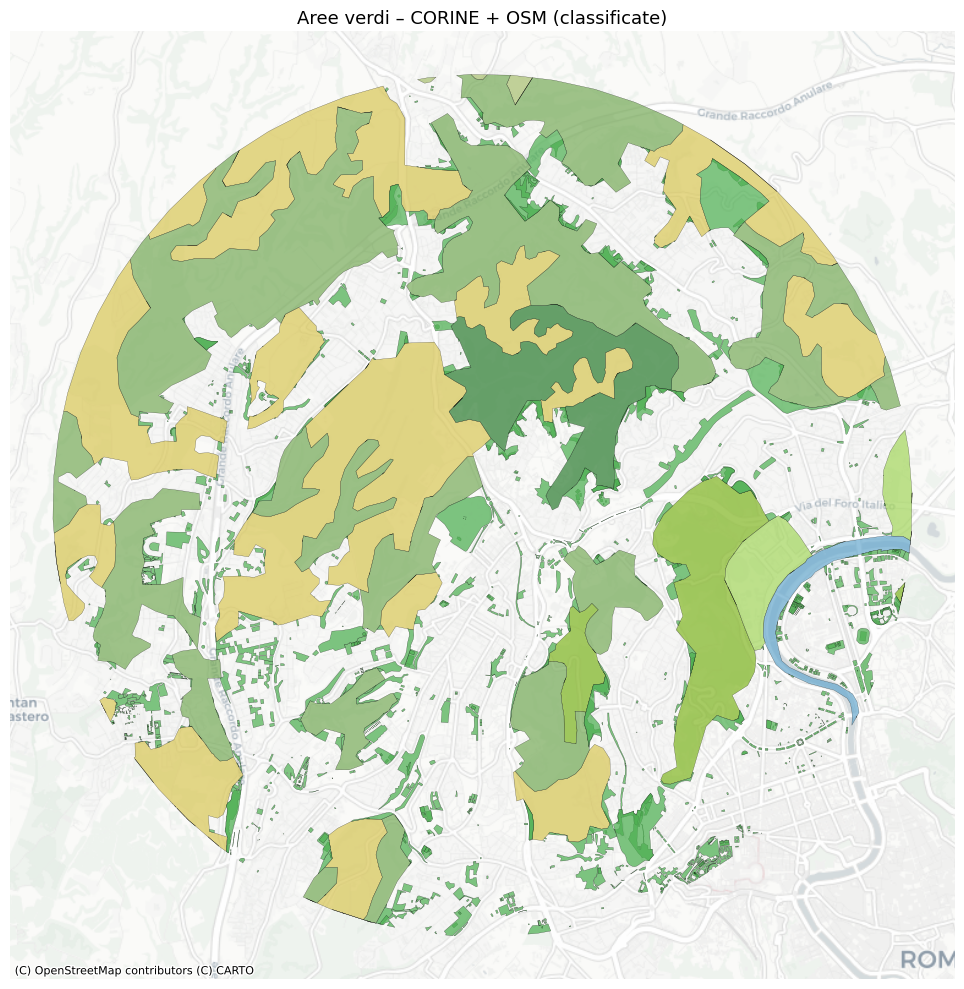

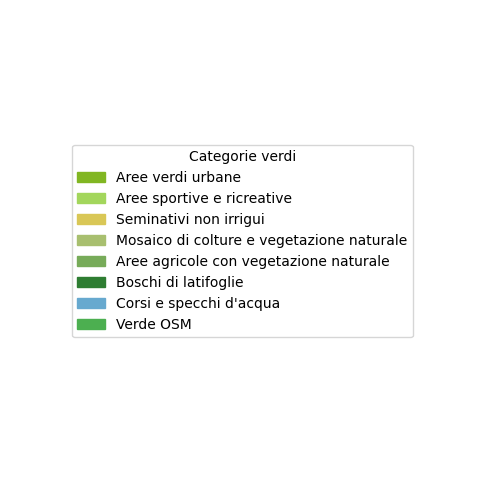

In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

# === Assumiamo che esistano già ===
# gdf_clip: layer CORINE ritagliato e in CRS metrico
# verde_osm3857: aree verdi OSM in EPSG:3857

# ==========================================
# 1️⃣ Filtra CORINE solo per le classi "verdi"
# ==========================================
corine_verdi_codici = ["141", "142", "211", "242", "243", "311", "511"]

corine_labels_it = {
    "141": "Aree verdi urbane",
    "142": "Aree sportive e ricreative",
    "211": "Seminativi non irrigui",
    "242": "Mosaico di colture e vegetazione naturale",
    "243": "Aree agricole con vegetazione naturale",
    "311": "Boschi di latifoglie",
    "511": "Corsi e specchi d'acqua"
}

corine_verde = gdf_clip[gdf_clip["CODE_18"].isin(corine_verdi_codici)].copy()
corine_verde = corine_verde.to_crs(3857)
corine_verde["fonte"] = "CORINE"
corine_verde["categoria"] = corine_verde["CODE_18"].map(corine_labels_it)

print(f"✅ CORINE verde: {len(corine_verde)} poligoni")

# ==========================================
# 2️⃣ Assicurati che gli OSM siano nel CRS corretto
# ==========================================
verde_osm3857 = verde_osm3857.to_crs(3857)

# ==========================================
# 3️⃣ Seleziona solo OSM che NON intersecano CORINE verde
# ==========================================
print("➡️ Calcolo differenza spaziale (OSM - CORINE verde)...")
osm_extra = gpd.overlay(verde_osm3857, corine_verde, how="difference")
print(f"✅ Aree verdi aggiuntive trovate: {len(osm_extra)}")

# ==========================================
# 4️⃣ Crea layer finale unificato con classificazione
# ==========================================
osm_extra["fonte"] = "OSM"
osm_extra["categoria"] = "Verde OSM"

# Uniforma le colonne
cols = ["fonte", "categoria", "geometry"]
layer_finale = pd.concat([corine_verde[cols], osm_extra[cols]], ignore_index=True)

print(f"🌿 Layer verde finale: {len(layer_finale)} poligoni totali")

# ==========================================
# 5️⃣ Calcolo aree e percentuali
# ==========================================
layer_finale["area_m2"] = layer_finale.geometry.area
df_area = (
    layer_finale.groupby("categoria")["area_m2"]
    .sum()
    .reset_index()
    .sort_values("area_m2", ascending=False)
)
df_area["perc"] = 100 * df_area["area_m2"] / df_area["area_m2"].sum()

print("\n📊 Superfici per categoria:")
print(df_area)

# ==========================================
# 6️⃣ Palette coerente per visualizzazione
# ==========================================
palette = {
    "Aree verdi urbane": "#81B622",
    "Aree sportive e ricreative": "#A3D65C",
    "Seminativi non irrigui": "#D9C756",
    "Mosaico di colture e vegetazione naturale": "#A8BF6F",
    "Aree agricole con vegetazione naturale": "#77AB59",
    "Boschi di latifoglie": "#2E7D32",
    "Corsi e specchi d'acqua": "#67A9CF",
    "Verde OSM": "#4caf50"
}
layer_finale["color"] = layer_finale["categoria"].map(palette).fillna("#cccccc")

# ==========================================
# 7️⃣ Mappa finale
# ==========================================
fig, ax = plt.subplots(figsize=(10, 10))

layer_finale.plot(
    ax=ax,
    color=layer_finale["color"],
    edgecolor="k",
    linewidth=0.2,
    alpha=0.7
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Aree verdi – CORINE + OSM (classificate)", fontsize=13)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ==========================================
# 8️⃣ (Facoltativo) Legenda compatta
# ==========================================
import matplotlib.patches as mpatches

handles = [
    mpatches.Patch(color=palette[c], label=c)
    for c in layer_finale["categoria"].unique()
]
fig, ax = plt.subplots(figsize=(6, 6))
ax.legend(handles=handles, title="Categorie verdi", loc="center", frameon=True)
ax.axis("off")
plt.show()
